In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
path = '/content/gdrive/Team Drives/cs273p project'
sys.path.append(path)

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


import re
from nltk.stem import WordNetLemmatizer 
import nltk
nltk.download('wordnet') 

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# import data_loader


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
train_file_path = path + '/data/train.csv'
test_file_path = path + '/data/test.csv'
test_label_file_path = path + '/data/test_labels.csv'

train_df, valid_df = data_loader.load_train_data(train_file_path, valid_rate=0.1, is_df=True)
test_df = data_loader.load_test_data(test_file_path, test_label_file_path, is_df=True)

In [0]:
print("train_df.shape: ", train_df.shape)
print("valid_df.shape: ", valid_df.shape)
print("test_df.shape: ", test_df.shape) 

train_df.shape:  (143645, 8)
valid_df.shape:  (15926, 8)
test_df.shape:  (63978, 8)


# Load saved data

In [0]:
import pickle

def saveobj(save_list, filename):
    with open(path + '/' + filename, 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump(save_list, f)
        
# restore object        
def loadobj(filename):
    with open(path + '/' + filename, 'rb') as f:  # Python 3: open(..., 'rb')
        li = pickle.load(f)
    return li

In [0]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [0]:
train_df, valid_df, test_df = loadobj('data/filtered_comment_pickle')

## Preprocessed Visualization
1. any missing values "null"

2. Statistics of each class 
   - percentage
      - not labeled
      - each class
      
3. correlation between classes
   - heatmap 
       - filter out all zero comment
       - compare among classes

No any missing values from the trainning data

In [0]:
train_df.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

Probability of each class being 1

In [0]:
train_df[classes].mean() 

toxic            0.096084
severe_toxic     0.010018
obscene          0.053277
threat           0.003021
insult           0.049664
identity_hate    0.008786
dtype: float64

In [0]:
nonToxicProb = (train_df[classes] == 0).all(axis = 1).mean() * 100
print("Probability of non toxic comment is {}%".format(nonToxicProb))

Probability of non toxic comment is 89.80890389501897%


Text(0.5, 1.0, 'Classes correlation')

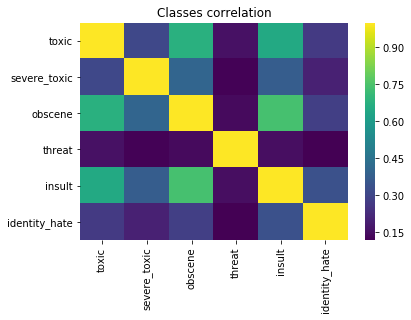

In [0]:
cls_corr = train_df[classes].corr()
color = plt.cm.viridis
sns.heatmap(cls_corr, cmap = color)
plt.title("Classes correlation")

The heatmap above shows stronger correlation among:
(toxic, obscene,  insult)

Then,  those classes have  a weaker correlation to severe_toxic

The identity_hate and threat have the weakest correlation to other classes

## Preprocessing

### Text Cleaning
1. Lowercasing
2. Remove punctuation
3. Remove marginal white space or newline
      - strip left and right
      - \n
4. Remove stop words
5. Lemmatization

### After clean up, remove empty string

In [0]:
lemtzr = WordNetLemmatizer() 

def dataCleaning(row, lower = False):
  txt = row['comment_text']
  if lower:
    txt = txt.lower() 
  
  ## expand contraction 
  ## code from https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
  txt = re.sub(r"won\'t", "will not", txt)
  txt = re.sub(r"can\'t", "can not", txt)
  txt = re.sub(r"n\'t", " not", txt)
  txt = re.sub(r"\'re", " are", txt)
  txt = re.sub(r"\'s", " is", txt)
  txt = re.sub(r"\'d", " would", txt)
  txt = re.sub(r"\'ll", " will", txt)
  txt = re.sub(r"\'t", " not", txt)
  txt = re.sub(r"\'ve", " have", txt)
  txt = re.sub(r"\'m", " am", txt)
  
  txt = re.sub('\W', ' ', txt)                                                  # remove non word characters
  txt = re.sub('\s+', ' ', txt)                                                 # remove white spaces
  
  txt = ' '.join([lemtzr.lemmatize(wrd) for wrd in txt.split(' ')])             # lemmatize
  return txt.strip()



In [0]:
train_df['filt_comment'] = train_df.apply(dataCleaning, axis = 1)
valid_df['filt_comment'] = valid_df.apply(dataCleaning, axis = 1)
test_df['filt_comment'] = test_df.apply(dataCleaning, axis = 1)

## Vectorized and Transform 

In [0]:
train_txt = train_df.filt_comment
valid_txt = valid_df.filt_comment
test_txt = test_df.filt_comment

In [0]:
word_vect = TfidfVectorizer(analyzer = 'word',
                            token_pattern = '\w+',
                            stop_words = 'english',
                            lowercase = True,
                            strip_accents='unicode',
                            sublinear_tf=True,
                            max_features = 10000)  

train_wrd = word_vect.fit_transform(train_txt)
valid_wrd = word_vect.transform(valid_txt)
test_wrd = word_vect.transform(test_txt)

In [0]:
char_vect = TfidfVectorizer(analyzer = 'char',
                            stop_words = 'english',
                            lowercase = True,
                            ngram_range = (3, 6),
                            strip_accents='unicode',
                            sublinear_tf=True,
                            max_features = 10000)
  

train_char = char_vect.fit_transform(train_txt)
valid_char = char_vect.transform(valid_txt)
test_char = char_vect.transform(test_txt)

In [0]:
train_X = hstack([train_wrd, train_char])
valid_X = hstack([valid_wrd, valid_char])
test_X = hstack([test_wrd, test_char])


## Model
Other options might include feature design, or optimizing your models to deal with special aspects of the data (missing features, too many features, large numbers of zeros in the data; possible outlier data; etc.). Your report should describe what aspects you chose to focus on.

Find optimal regularization coefficient:

In [0]:
reg_coeff = [0.1, 0.3, 0.5, 0.7, 1, 1.5, 2, 2.5]
train_scores = np.zeros((len(classes), len(reg_coeff)))
valid_scores = np.zeros((len(classes), len(reg_coeff)))

testfile = "/output/logistic/reg_coef_test.pickle"
trainfile = "/output/logistic/reg_coef_train.pickle"


for reg_ind, reg in enumerate(reg_coeff):
  for cls_ind, clas in enumerate(classes):
    print("reg: {}, class: {}".format(reg, clas))
    classifier = LogisticRegression(C = 1/reg, solver='sag') #, random_state = i 
    
    
    classifier.fit(train_X, train_df[clas])
    train_pred_Y = classifier.predict_proba(train_X)[:,1]
    valid_pred_Y = classifier.predict_proba(valid_X)[:,1]
    
    train_scores[cls_ind][reg_ind] = roc_auc_score(train_df[clas], train_pred_Y)
    valid_scores[cls_ind][reg_ind] = roc_auc_score(valid_df[clas], valid_pred_Y)
    
    saveobj(train_scores, trainfile)
    saveobj(valid_scores, testfile)

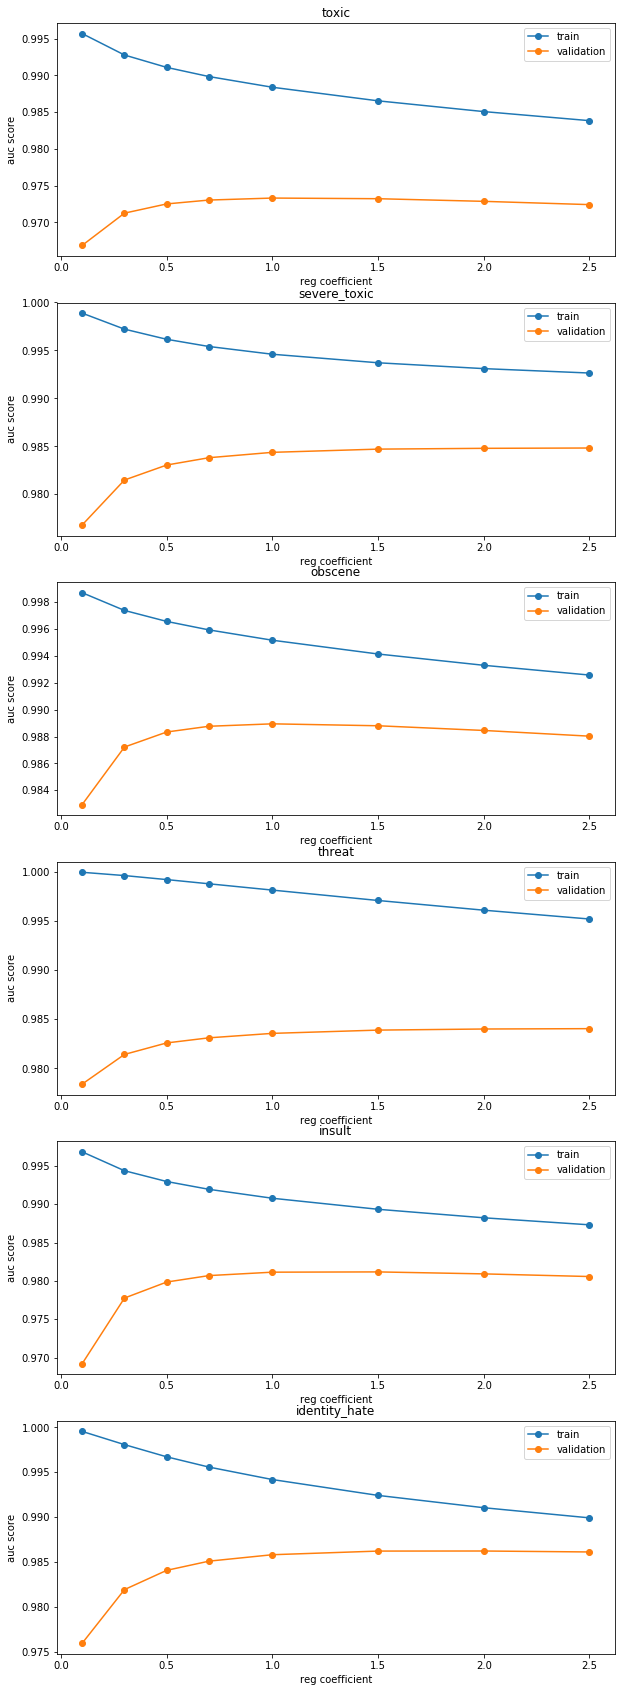

In [0]:
fig, ax = plt.subplots(6, 1, figsize = (10, 30))

for cls_ind, clas in enumerate(classes):
  ax[cls_ind].plot(reg_coeff, train_scores[cls_ind], '-o')
  ax[cls_ind].plot(reg_coeff, valid_scores[cls_ind], '-o')
  ax[cls_ind].set_title(clas)
  ax[cls_ind].set_ylabel("auc score")
  ax[cls_ind].set_xlabel("reg coefficient")
  ax[cls_ind].legend(['train', 'validation'])
 

These plots indicates that the optimized regularization coefficients are different for each classes. Therefore, we decided to use different alpha for each classes. We selected alpha, which produces the highest validation score.

*  toxic:                  1
*  severe_toxic:    2
*  obscene:           1
*  threat:                2.5
*  insult:                 1.5 
*  identity_hate:    2



## Binary Model Perdiction 
(reference: https://www.kaggle.com/tunguz/logistic-regression-with-words-and-char-n-grams)

In [0]:
classifier_name = 'logistic'

cls_reg_coeff = {'toxic': 1, "severe_toxic": 2, "obscene": 1, "threat": 2.5, "insult": 1.5, "identity_hate": 2}

train_scores = np.zeros(len(classes))
valid_scores = np.zeros(len(classes))
test_scores  = np.zeros(len(classes))

valid_predict = pd.DataFrame.from_dict({'id': valid_df['id']})
test_predict = pd.DataFrame.from_dict({'id': test_df['id']})

bin_valid_predict = pd.DataFrame.from_dict({'id': valid_df['id']})
bin_test_predict = pd.DataFrame.from_dict({'id': test_df['id']})


for cls_ind, clas in enumerate(classes):  
  reg = cls_reg_coeff[clas]
  classifier = LogisticRegression(C = 1/reg, solver='sag') #, random_state = i 
  
  classifier.fit(train_X, train_df[clas])
  train_pred_Y = classifier.predict_proba(train_X)[:,1]
  valid_predict[clas] = classifier.predict_proba(valid_X)[:,1]
  test_predict[clas] = classifier.predict_proba(test_X)[:,1]


  bin_valid_predict[clas] = classifier.predict(valid_X)
  bin_test_predict[clas] = classifier.predict(test_X)

  train_scores[cls_ind] = roc_auc_score(train_df[clas], train_pred_Y)
  valid_scores[cls_ind] = roc_auc_score(valid_df[clas], valid_predict[clas])
  test_scores[cls_ind]  = roc_auc_score(test_df[clas], test_predict[clas])

  print("{}: train_score {}, valid_score {}, test_scores {}".format(clas,\
                                                                    train_scores[cls_ind], valid_scores[cls_ind],
                                                                    test_scores[cls_ind]) )
print("\navg: train_score {}, valid_score {}, test_scores {}".format(clas,\
                                                                np.mean(train_scores[cls_ind]), np.mean(valid_scores[cls_ind]),
                                                                np.mean(test_scores[cls_ind])) )

test_predict.to_csv(path + "/output/{}/prob_{}_test_submission.csv".format(classifier_name, classifier_name))
valid_predict.to_csv(path + "/output/{}/prob_{}_valid_submission.csv".format(classifier_name, classifier_name))

bin_test_predict.to_csv(path + "/output/{}/bin_{}_test_submission.csv".format(classifier_name, classifier_name))
bin_valid_predict.to_csv(path + "/output/{}/bin_{}_valid_submission.csv".format(classifier_name, classifier_name))
  

toxic: train_score 0.9883978337049395, valid_score 0.9726290899391925, test_scores 0.9627031795615065
severe_toxic: train_score 0.9929839740461274, valid_score 0.9849401655203811, test_scores 0.9865834302731645
obscene: train_score 0.9953035588361027, valid_score 0.9887869619080201, test_scores 0.9760321887020712
threat: train_score 0.9952398553943174, valid_score 0.98381815892205, test_scores 0.9911824647151058
insult: train_score 0.9894884270702584, valid_score 0.9812662812919706, test_scores 0.9708519626906256
identity_hate: train_score 0.9912865344452247, valid_score 0.9860095552929615, test_scores 0.9844130449569626

avg: train_score identity_hate, valid_score 0.9912865344452247, test_scores 0.9860095552929615


## Chain Logistic
The heapmap above shows strong correlation among toxic, obscene, insult classes. Therefore, we design a model to allow previous prediction to influence later prediction on other classes to improve the accuracy of our prediction. 
Since the heatmap shows stronger correlation between 

*  'toxic'
*  'obscene'
*  'insult' 

We decide to use chained classifier to strengthen the prediction of those classes. 
We used compressed sparse row matrix to provide efficent way to store data.
The class "toxic" has the lowest scores from binary classification. Therefore, we used the predicted result of 'obscene' and 'insult'  as the input feature to predict the toxic class.

(reference: https://www.kaggle.com/rhodiumbeng/classifying-multi-label-comments-0-9741-lb/output?fbclid=IwAR3h0mIamwhtqvb3Zpr1Sm7oofKGOWp0LYujV1XIyDCqftw9ulo_2QzzO7E)

## Regularization

In [0]:
reordered_cls = ['obscene', 'insult', 'toxic']

reg_coeff = [0.1, 0.3, 0.5, 0.7, 1, 1.5, 2, 2.5]
chain_train_scores = np.zeros((len(reordered_cls), len(reg_coeff)))
chain_valid_scores = np.zeros((len(reordered_cls), len(reg_coeff)))

testfile = "/output/logistic/chain_reg_coef_test.pickle"
trainfile = "/output/logistic/chain_reg_coef_train.pickle"


add_chain_feat = lambda X, new_feat: hstack([X, csr_matrix(new_feat).T], 'csr')

for reg_ind, reg in enumerate(reg_coeff):
  _train_X, _valid_X = train_X, valid_X
  
  for cls_ind, clas in enumerate(reordered_cls):
    
    print('reg: {}, clas: {}'.format(reg, clas))
    classifier = LogisticRegression(C = 1/reg, solver='sag') #, random_state = i 

    classifier.fit(_train_X, train_df[clas])
    train_pred_Y = classifier.predict_proba(_train_X)[:, 1]
    valid_pred_Y = classifier.predict_proba(_valid_X)[:, 1]

    _train_X = add_chain_feat(_train_X, train_df[clas])
    _valid_X = add_chain_feat(_valid_X, valid_pred_Y)

    chain_train_scores[cls_ind][reg_ind] = roc_auc_score(train_df[clas], train_pred_Y)
    chain_valid_scores[cls_ind][reg_ind] = roc_auc_score(valid_df[clas], valid_pred_Y)
    
    
    
    saveobj(chain_train_scores, trainfile)
    saveobj(chain_valid_scores, testfile)

#     print("class: {}: training score is {}, validation score is {}".format(clas, chain_train_scores[cls_ind], chain_valid_scores[cls_ind]))

The result of chain model does not show improvement in validation score. Therefore, we decide to use the binary model directly.

## Chain Model with tuned reg coefficient

In [1]:
cls_reg_coeff = {'toxic': 1, "severe_toxic": 2, "obscene": 1, "threat": 2.5, "insult": 1, "identity_hate": 2}

reordered_cls = ['obscene', 'insult', 'toxic']

chain_train_scores = np.zeros(len(reordered_cls))
chain_valid_scores = np.zeros(len(reordered_cls))
chain_test_scores = np.zeros(len(reordered_cls))

chain_test_predict = pd.DataFrame.from_dict({'id': test_df['id']})

_train_X, _valid_X, _test_X = train_X, valid_X, test_X

add_chain_feat = lambda X, new_feat: hstack([X, csr_matrix(new_feat).T], 'csr')

for cls_ind, clas in enumerate(reordered_cls):
  reg = cls_reg_coeff[clas]
  classifier = LogisticRegression(C = 1/reg, solver='sag') #, random_state = i 


  classifier.fit(_train_X, train_df[clas])
  train_pred_Y = classifier.predict_proba(_train_X)[:, 1]
  valid_pred_Y = classifier.predict_proba(_valid_X)[:, 1]
  chain_test_predict[clas] = classifier.predict_proba(_test_X)[:, 1]
  
  _train_X = add_chain_feat(_train_X, train_df[clas])
  _valid_X = add_chain_feat(_valid_X, valid_pred_Y)
  _test_X = add_chain_feat(_test_X, chain_test_predict[clas])
  
  chain_train_scores[cls_ind] = roc_auc_score(train_df[clas], train_pred_Y)
  chain_valid_scores[cls_ind] = roc_auc_score(valid_df[clas], valid_pred_Y)
  chain_test_scores[cls_ind]  = roc_auc_score(test_df[clas], chain_test_predict[clas])
  
  print("{}: train_score {}, valid_score {}, test_scores {}".format(clas,\
                                                                    chain_train_scores[cls_ind], chain_valid_scores[cls_ind],
                                                                    chain_test_scores[cls_ind]) )
print("avg: train_score {}, valid_score {}, test_scores {}".format(
                                                                np.mean(chain_train_scores[cls_ind]), np.mean(chain_valid_scores[cls_ind]),
                                                                np.mean(chain_test_scores[cls_ind])) )
  
  
  

NameError: ignored

avg: train_score 0.9893483426451878, valid_score 0.9713061597561016, test_scores 0.9604171361197116
